<a href="https://colab.research.google.com/github/mphipps2/SemanticSegmentation_SAR_Images/blob/main/SemanticSegmentation_SAR_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Analysis Outline

**1.   Load images/masks**

**2.   Dataset exploration**

- How many images/masks do we have? <font color='red'>790 of each</font> 
- What do images and masks look like?
- How many from each class in dataset? <font color='red'>
  - Background: 40,654,521 pixels <font color='red'>(98.15%)</font>
  - Seep 1: 428,563 pixels <font color='red'>(1.03%)</font>
  - Seep 2: 49,491 pixels <font color='red'>(0.12%)</font>
  - Seep 3: 18,677 pixels <font color='red'>(0.05%)</font>
  - Seep 4: 35,942 pixels <font color='red'>(0.09%)</font>
  - Seep 5: 130,601 pixels <font color='red'>(0.32%)</font>
  - Seep 6: 93,978 pixels <font color='red'>(0.23%</font>
  - Seep 7: 6,979 pixels <font color='red'>(0.02%)</font>


- How frequently does an image have an empty mask? <font color='red'>only 2 images with no seeps</font> 

**3.    Partition data: train/validation/test**

**4.    Data augmentation**

**5.    Derive class weights**

**6.    Normalize images and one-hot-encode the masks**

**7.    Define network architecture: multi-class U-Net**

**8.    Training**

**7.    Performance assessment**


##Load Libraries

In [ ]:


import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import os
import sys
import random
from datetime import datetime
from google.colab import drive
drive.mount('/content/gdrive')

# image processing
import glob
import cv2

# tensorflow 
#from tensorboard.plugins.hparams import api as hp

#from tensorflow.contrib.training import HParams
from tensorflow.python.keras.utils.data_utils import Sequence, is_generator_or_sequence
from tensorflow.python.keras.callbacks import TensorBoard
!pip install tensorflow-addons
import tensorflow_addons as tfa
#%load_ext tensorboard

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D, Input,  Dropout, Lambda, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import normalize, to_categorical

# sklearn
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# visualization
from itertools import cycle, product
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# preprocessing and data augmentation
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user
from albumentations import Compose, HorizontalFlip, VerticalFlip, Rotate, RandomRotate90, Transpose

# metrics
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score, auc
from keras.metrics import MeanIoU

print('graphics card:')
!nvidia-smi

## Load Images

In [ ]:
SIZE_X = 256
SIZE_Y = 256
TOTAL_IMAGES = 790
N_CLASSES = 8

do_resize = False

path_img = 'gdrive/My Drive/Colab Notebooks/Data/seep_detection/train_images_256/*.tif' 
path_mask = 'gdrive/My Drive/Colab Notebooks/Data/seep_detection/train_masks_256/*.tif' 

all_img_list = []
all_mask_list = []

# first sort image and mask names to make sure their order is aligned
image_names = glob.glob(path_img)
image_names.sort()
mask_names = glob.glob(path_mask)
mask_names.sort()
#print(image_names)
#print(mask_names)

for filename in image_names:
  img = cv2.imread(filename,-1)
  if do_resize:
    img = cv2.resize(img, (SIZE_Y, SIZE_X))   
  all_img_list.append(img) 
  del img

for filename in mask_names:
  mask = cv2.imread(filename,-1)
  if do_resize:
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
  all_mask_list.append(mask)
  del mask
# convert list of ndarray to ndarray of ndarray
all_img = np.array(all_img_list)
all_mask = np.array(all_mask_list)

print('# of training images: ', len(all_img))

print('# of training masks: ', len(all_mask))

del all_img_list
del all_mask_list



## Load Visualization Routines

In [2]:
def visualize_img_mask(image, mask):

  plt.figure(figsize=(25,18))
  plt.subplot(221)
  plt.title('Image ' + str(img_number))
  plt.imshow(img, cmap='gray', vmin=0, vmax=65535)
  plt.colorbar()
  plt.subplot(222)
  plt.title('Mask ' + str(img_number))
  plt.imshow(mask,cmap='Set2')
  plt.clim(0,7)
  plt.colorbar()
  plt.show()


def visualize_augmentation(image, mask, original_image=None, original_mask=None):
  fontsize = 18
    
  if original_image is None and original_mask is None:
    f, ax = plt.subplots(2, 1, figsize=(8, 8))
    ax[0].imshow(image)
    ax[1].imshow(mask)
  else:
    f, ax = plt.subplots(2, 2, figsize=(8, 8))

    img_0 = ax[0, 0].imshow(original_image, cmap='gray', vmin=0, vmax=65535)
    ax[0, 0].set_title('Original image', fontsize=fontsize)
        
    ax[1, 0].imshow(original_mask,cmap='Set2')
    ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
    ax[0, 1].imshow(image, cmap='gray', vmin=0, vmax=65535)
    ax[0, 1].set_title('Augmented image', fontsize=fontsize)
        
    ax[1, 1].imshow(mask,cmap='Set2')
    ax[1, 1].set_title('Augmented mask', fontsize=fontsize)

    plt.figure(figsize=(25,18))


def visualize_pr(recall, precision, n_classes):
  colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

  plt.figure(figsize=(14, 8))
  f_scores = np.linspace(0.2, 0.8, num=4)
  lines = []
  labels = []
  for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

  lines.append(l)
  labels.append('iso-f1 curves')
  l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
  lines.append(l)
  labels.append('micro-average Precision-recall (area = {0:0.2f})'
                ''.format(average_precision["micro"]))

  for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Recall')
  plt.ylabel('Precision') 
  plt.title('Precision-Recall curve to multi-class')
  plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))

  plt.show()


def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.
    
  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(10, 8))
   
  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
   
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, aspect='auto')
  plt.title("Normalized confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

def visualize_img_target_pred(img, target, pred):

  fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=False,
                          figsize=(30,7))
  pcm1 = axes[0].pcolormesh(img, cmap='gray', vmin=0, vmax=65535)
  # Place first colorbar on first column - index 0
  fig.colorbar(pcm1, ax=axes[0])
  pcm2 = axes[1].pcolormesh(target, cmap='Set2')
  pcm2.set_clim(0,7)
  # Place second colorbar on second column - index 1
  fig.colorbar(pcm2, ax=axes[1])
  pcm3 = axes[2].pcolormesh(pred, cmap='Set2')
  pcm3.set_clim(0,7)
  # Place second colorbar on second column - index 1
  fig.colorbar(pcm3, ax=axes[2])
  plt.show()

## Dataset Exploration 

In [ ]:
# Dataset statistics 

print('img type: ', type(all_img), ' img shape: ', all_img.shape, ' element type: ', type(all_img[0][0][0]))
print('mask type: ', type(all_mask), ' img shape: ', all_mask.shape, ' element type: ', type(all_mask[0][0][0]))
print('unique elements of mask: ' , np.unique(all_mask))


img type:  <class 'numpy.ndarray'>  img shape:  (790, 256, 256)  element type:  <class 'numpy.uint8'>
mask type:  <class 'numpy.ndarray'>  img shape:  (790, 256, 256)  element type:  <class 'numpy.uint8'>
unique elements of mask:  [0 1 2 3 4 5 6 7]


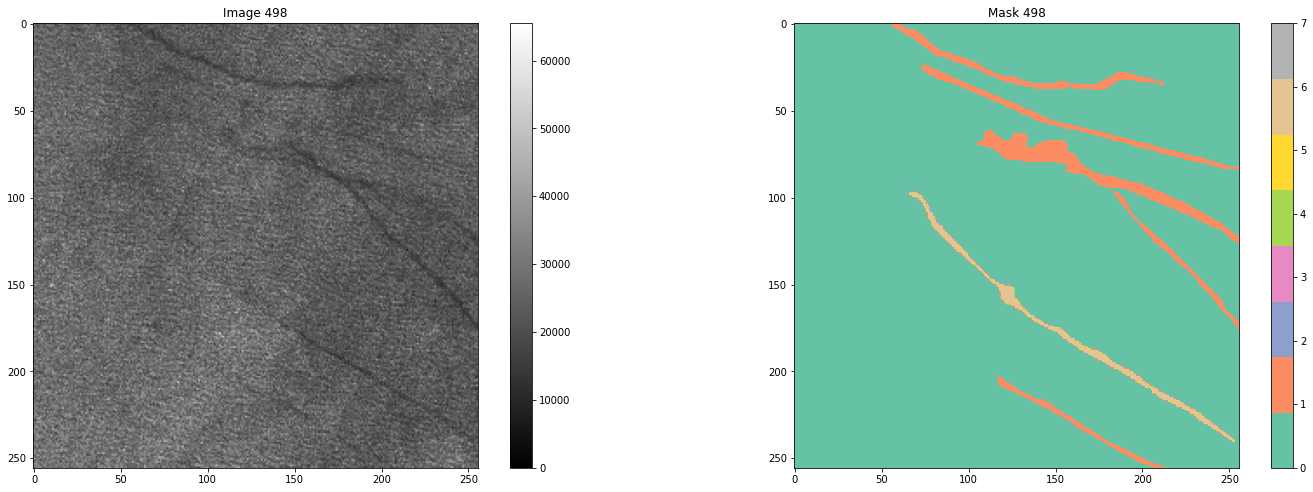

In [13]:

img_number = random.randint(0, len(all_img))
img = all_img[img_number]
mask = all_mask[img_number]
visualize_img_mask(img, mask)

In [ ]:
# check how many images don't contain any seeps. If this is high, these could be cut from training

print('The following events do not contain seeps:')
for i, val in enumerate(all_mask):
  sum = val.sum()
  if sum == 0:
    print('i: ', i, ' sum: ', sum)

The following events do not contain seeps:
i:  177  sum:  0
i:  749  sum:  0


## Partition Data: Train/Validation/Test

In [ ]:
train_ratio = 0.48
test_val_ratio = 0.5

train_x, tmp_x   = train_test_split(all_img, train_size = train_ratio, shuffle = True, random_state = 7)
val_x, test_x    = train_test_split(tmp_x, train_size = test_val_ratio, shuffle = True, random_state = 7)
train_y, tmp_y   = train_test_split(all_mask, train_size = train_ratio, shuffle = True, random_state = 7)
val_y, test_y    = train_test_split(tmp_y, train_size = test_val_ratio, shuffle = True, random_state = 7)

print('training_size: ', len(train_x), ' val_size: ', len(val_x), ' test_size: ', len(test_x))

N_TRAINING_EVENTS = train_x.shape[0]
N_TEST_EVENTS = test_x.shape[0]

IMG_HEIGHT = train_x.shape[1]
IMG_WIDTH  = train_x.shape[2]

del all_img
del all_mask
del tmp_x
del tmp_y

training_size:  379  val_size:  205  test_size:  206


## Data Augmentation:
There are eight independent representations of a single square image on a plane (shown below). Each training image and its mask will be modified by these transforms, such that the final training set is 8x larger. These transforms will help the model learn abstract representations of each class that are more rotationally and translationally invariant. They'll also allows us to significantly increase the number of training events, giving the model more exposure to minority classes. Note: augmentation will only be performed on training data; validation and test data are unmodified.

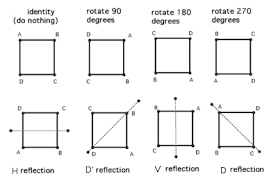

In [ ]:
random.seed(7)

AUG = []

AUG.append( Compose([
    Rotate(limit=[90.,90.], p=1.)]))
AUG.append( Compose([
    Rotate(limit=[180.,180.], p=1.)]))
AUG.append( Compose([
    Rotate(limit=[270.,270.], p=1.)]))
AUG.append( Compose([
    VerticalFlip(p=1.)]))
AUG.append( Compose([
    VerticalFlip(p=1.),
    Rotate(limit=[90.,90.], p=1.)]))
AUG.append( Compose([
    VerticalFlip(p=1.),
    Rotate(limit=[180.,180.], p=1.)]))
AUG.append( Compose([
    VerticalFlip(p=1.),
    Rotate(limit=[270.,270.], p=1.)]))
# Identity 
AUG.append( Compose([]))

augmented_imgs = []
augmented_masks = []
N_LOOPS = 8

for i in range(N_LOOPS):
  for j in range(N_TRAINING_EVENTS):
    augmented = AUG[i](image=train_x[j], mask=train_y[j])
    augmented_imgs.append(augmented['image'])
    augmented_masks.append(augmented['mask'])

print('aug_imgs: ', len(augmented_imgs), ' aug_masks ', len(augmented_masks))

aug_imgs:  3032  aug_masks  3032


Image number:  44


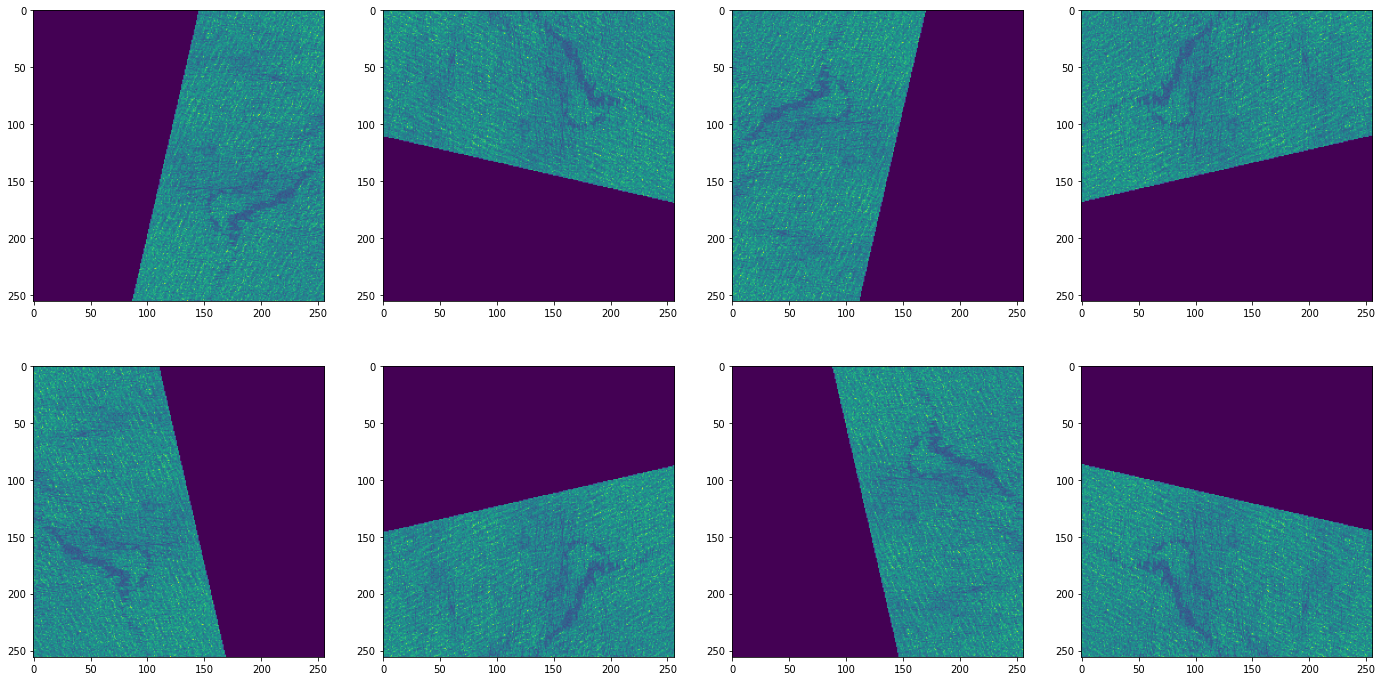

In [ ]:
# single image with 8 different augmentations
img_number = random.randint(0, len(train_x))
print('Image number: ', img_number)
fig = plt.figure(figsize=(24,12))
for i in range(2):
    for j in range(4):
        ax = fig.add_subplot(2, 4, i * 4 + j + 1)
        ax.imshow((AUG[(i*4) + j](image=train_x[img_number])["image"]).astype(np.uint8))

Image number:  10


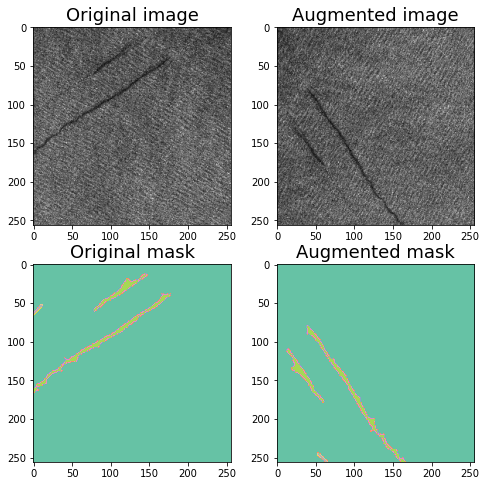

<Figure size 1800x1296 with 0 Axes>

In [ ]:
# Compare original image/mask to augmented image/mask

img_number = random.randint(0, len(train_x))
print('Image number: ', img_number)
visualize_augmentation(augmented_imgs[img_number], augmented_masks[img_number], train_x[img_number], train_y[img_number])


In [ ]:
augmented_imgs = np.array(augmented_imgs)
augmented_masks = np.array(augmented_masks)

train_x = augmented_imgs
del augmented_imgs
train_y = augmented_masks
del augmented_masks
print ('Data shape after augmenting', train_x.shape)
TOTAL_IMAGES = train_x.shape[0]

Data shape after augmenting (3032, 256, 256)


## Derive Class Weights

In [ ]:
# classes not equally balanced. So derive class weights from training set to correct for imbalance in our model
# First must flatten vector to work with compute_class_weight function 

print('train_y shape: ', train_y.shape )
train_y_1d = train_y.reshape(-1)
print(' train_y_1d shape: ', train_y_1d.shape)
classes = np.unique(train_y_1d)
print('unique elements of mask: ' , classes )

# if ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y))
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = classes,
                                        y = train_y_1d                                                    
                                    )
print('samples per class: ', np.bincount(train_y_1d))

train_y_2d = np.reshape(train_y, (train_y.shape[0], SIZE_X*SIZE_Y))
sample_weights = np.zeros((train_y.shape[0],SIZE_X*SIZE_Y))
for i in range(N_CLASSES):
    sample_weights[np.where(train_y_2d == i)] = class_weights[i]

print('unique elements of sample weights: ' , np.unique(sample_weights))
print('class_weights: ', class_weights)
print('sample_weights shape: ', sample_weights.shape)
del train_y_1d
del train_y_2d


train_y shape:  (3032, 256, 256)
 train_y_1d shape:  (198705152,)
unique elements of mask:  [0 1 2 3 4 5 6 7]
samples per class:  [194730312   2167789    228119     86130    191612    777696    482580
     40914]
unique elements of sample weights:  [1.27551503e-01 1.14578236e+01 3.19381146e+01 5.14694849e+01
 1.08882399e+02 1.29627288e+02 2.88379705e+02 6.07081781e+02]
class_weights:  [1.27551503e-01 1.14578236e+01 1.08882399e+02 2.88379705e+02
 1.29627288e+02 3.19381146e+01 5.14694849e+01 6.07081781e+02]
sample_weights shape:  (3032, 65536)


## Normalize Images and One-hot-encode the Masks

In [ ]:
print('Before: img type: ', type(train_x), ' img shape: ', train_x.shape, ' element type: ', type(train_x[0][0][0]))
print('Before: mask type: ', type(train_y), ' mask shape: ', train_y.shape, ' element type: ', type(train_y[0][0][0]))

# expand dimension by 1 such that each image has a classification weight
train_x = np.expand_dims(train_x, axis=3)
train_y = np.expand_dims(train_y, axis=3)
val_x = np.expand_dims(val_x, axis=3)
val_y = np.expand_dims(val_y, axis=3)
test_x = np.expand_dims(test_x, axis=3)
test_y = np.expand_dims(test_y, axis=3)
# now all unsigned int elements become float64
train_x = normalize(train_x, axis=1)
val_x = normalize(val_x, axis=1)
test_x = normalize(test_x, axis=1)

print('After: img type: ', type(train_x), ' img shape: ', train_x.shape, ' element type: ', type(train_x[0][0][0][0]))
print('After: mask type: ', type(train_y), ' mask shape: ', train_y.shape, ' element type: ', type(train_y[0][0][0][0]))

# one hot encoding the label
train_y_cat = to_categorical(train_y, num_classes=N_CLASSES)
train_y_3d_cat = np.reshape(train_y_cat, (train_y.shape[0], SIZE_X*SIZE_Y, N_CLASSES))
del train_y, train_y_cat

val_y_cat = to_categorical(val_y, num_classes=N_CLASSES)
val_y_3d_cat = np.reshape(val_y_cat, (val_y.shape[0], SIZE_X*SIZE_Y, N_CLASSES))
del val_y, val_y_cat

test_y_cat = to_categorical(test_y, num_classes=N_CLASSES)
test_y_3d_cat = np.reshape(test_y_cat, (test_y.shape[0], SIZE_X*SIZE_Y, N_CLASSES))

print('val_x: ', val_x.shape, ' val_cat ', val_y_3d_cat.shape, ' train_cat ', train_y_3d_cat.shape, ' sample_weights: ', sample_weights.shape)
print('unique elements of mask: ' , np.unique(test_y_cat))

Before: img type:  <class 'numpy.ndarray'>  img shape:  (3032, 256, 256)  element type:  <class 'numpy.uint8'>
Before: mask type:  <class 'numpy.ndarray'>  mask shape:  (3032, 256, 256)  element type:  <class 'numpy.uint8'>
After: img type:  <class 'numpy.ndarray'>  img shape:  (3032, 256, 256, 1)  element type:  <class 'numpy.float64'>
After: mask type:  <class 'numpy.ndarray'>  mask shape:  (3032, 256, 256, 1)  element type:  <class 'numpy.uint8'>


## Define Network Architecture: Multi-class U-Net

The original U-Net model was proposed for biomedical image segmentation applications: https://arxiv.org/pdf/1505.04597.pdf. This is a fully convolutional model that does not include the fully connected classifying layers that often appear in CNNs. Instead, it consists of an initial convolutional encoder that down-samples images to a feature map followed by a convolutional decoder that up samples the feature map back to the input image size. Importantly, the model also includes connections between each decoder and correspondingly-sized encoder layers. This allows the final up-sampling layers to incorporate some of the finer details encoded by the initial decoding layers.  

The authors showed impressive segmentation results for U-Net with a minimal amount of training data. This was possible in large part by combining the model with large amounts of augmented data, as I've done in this study. Moreover, end-to-end training and inference with this model is relatively fast when paired with GPUs. 

In [ ]:
def unet_model(n_classes=8, start_neurons=64, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#original unet model: https://arxiv.org/pdf/1505.04597.pdf
#in original model, start_neurons = 64
    #inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs


    #Contraction path
    c1 = Conv2D(start_neurons*1, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(start_neurons*1, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(start_neurons*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(start_neurons*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(start_neurons*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(start_neurons*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(start_neurons*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(start_neurons*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(start_neurons*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(start_neurons*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(start_neurons*8, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(start_neurons*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(start_neurons*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(start_neurons*4, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(start_neurons*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(start_neurons*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(start_neurons*2, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(start_neurons*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(start_neurons*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(start_neurons*1, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(start_neurons*1, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(start_neurons*1, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    c10 = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    outputs = Reshape((IMG_WIDTH*IMG_HEIGHT, n_classes))(c10)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

## Training

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

my_min_delta = 0.0001
my_patience = 100
my_monitor = 'val_loss'
my_optimizer = 'adam'
# used with one-hot encoded target
#my_loss = 'categorical_crossentropy'
# used with 1d integer encoded target
#my_loss = 'sparse_categorical_crossentropy'
my_loss =  tfa.losses.SigmoidFocalCrossEntropy(gamma=5.)
loss_tag = 'focal_loss'
#loss_tag = my_loss
#my_loss = 'tfa.losses.SigmoidFocalCrossEntropy'
#my_loss = CB_sigmoid_focal_crossentropy(samples_per_class, n_classes, 0.999, 0.5)
#my_loss = CB_sigmoid_focal_crossentropy(class_weights_norm)
#my_loss = weighted_categorical_crossentropy(class_weights)
#dice_loss = sm.losses.DiceLoss(class_weights=class_weights_norm) 
#focal_loss = sm.losses.CategoricalFocalLoss()
#my_loss = dice_loss + (1 * focal_loss)
#my_loss = dice_loss
#my_metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
my_metrics = ['accuracy']
my_batch_size = 64
my_epochs = 500
model_type = 'multi_unet'
model_num = 21
#start_neurons=16
start_neurons=8
train_model = False
output_path = '/content/gdrive/My Drive/Colab Notebooks/Output/seep_detection/'


if train_model:

  model = unet_model(n_classes=N_CLASSES,start_neurons=start_neurons,IMG_HEIGHT=SIZE_Y, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=1)
  model.compile(optimizer=my_optimizer, loss=my_loss, metrics=my_metrics, sample_weight_mode="temporal")

  model.summary()
  # write a copy of the model summary to file
  f = open(f'{output_path}model{model_type}_{model_num}_{loss_tag}_summary.txt', 'w')
  model.summary(print_fn = lambda x: f.write(x+'\n'))
  f.close()
  #!rm -rf logs
  #log_dir = "logs" + datetime.now().strftime("%Y%m%d-%H%M%S")
  #tensorboard_callback = TensorBoard(log_dir = log_dir, histogram_freq = 1)
  
  early_stopping = EarlyStopping(min_delta = my_min_delta, patience = my_patience, monitor = my_monitor, restore_best_weights = True)

  print("Start Training:")

  #%tensorboard --logdir=logs

  history = model.fit(train_x, train_y_3d_cat, 
                      batch_size = my_batch_size, 
                      verbose=1, 
                      epochs=my_epochs, 
                      shuffle=True,
                      validation_data=(val_x, val_y_3d_cat), 
                      sample_weight=sample_weights,
                      #callbacks=[early_stopping, tensorboard_callback])
                      callbacks=[early_stopping])

  model.save(f'{output_path}model{model_type}_{model_num}_{loss_tag}.h5')

else:
  model = load_model(f'{output_path}model{model_type}_{model_num}_{loss_tag}.h5')

In [ ]:
del val_x, val_y_3d_cat, train_x, train_y_3d_cat

##Performance Assessment

In [ ]:

pred_y=model.predict(test_x)

class_names = ['Bkg', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']
pred_argmax = np.asarray(pred_y).argmax(axis=2)
pred_argmax = pred_argmax.reshape(pred_argmax.shape[0]*SIZE_X*SIZE_Y)
test_y_1d = test_y.reshape(test_y.shape[0]*SIZE_X*SIZE_Y)
cm = confusion_matrix(test_y_1d, pred_argmax )
fig_size = (10, 10)

#f = plt.figure(figsize=fig_size)

fig = plot_confusion_matrix(cm,class_names)

del test_y_1d

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{output_path}model{model_type}_{model_num}_{loss_tag}.png')
plt.show()

In [ ]:
_, acc = model.evaluate(test_x, test_y_3d_cat)
print("Accuracy is = ", (acc * 100.0), "%")

#IOU
pred_y=model.predict(test_x)
pred_y_argmax=np.argmax(pred_y, axis=2)
print('pred shape: ', pred_y.shape, 'test shape: ', test_y_3d_cat.shape,  " argmax shape ", pred_y_argmax.shape)



In [ ]:

n_classes = 8
IOU_keras = MeanIoU(num_classes=N_CLASSES)  
#print(test_y.shape, ' argmax ', pred_y_argmax)
IOU_keras.update_state(test_y[:,:,:,0], pred_y_argmax)
#IOU_keras.update_state(test_y[:,:,0], pred_y_argmax)

print("Mean IoU =", IOU_keras.result().numpy())
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
print('values type: ', type(values), ' shape: ', values.shape)


In [ ]:
def weighted_average(distribution, weights):
  
    numerator = sum([distribution[i]*weights[i] for i in range(len(distribution))])
    denominator = sum(weights)
    
    return round(numerator/denominator,2)


class_IoU = [] 

# write a copy of the model summary to file
f = open(f'{output_path}model{model_type}_{model_num}_{loss_tag}_iou.txt', 'w')
for i in range(N_CLASSES):
  class_IoU.append( values[i,i] / (values.sum(axis=1)[i] + (values.sum(axis=0)[i] - values[i,i])) )
  pred_str = f'IoU for class {i} is: {class_IoU[i]}'
  print(pred_str)
  f.write(pred_str+'\n')

print('IoU frequency weighted average: ', weighted_average(class_IoU, class_weights))
f.close()



In [ ]:
print('test y shape: ', test_y.shape)
test_img_number = random.randint(0, len(test_x))
test_img = test_x[test_img_number]
ground_truth = test_y[test_img_number]
ground_truth = np.reshape(ground_truth,(SIZE_X,SIZE_Y,1))
#test_y = np.reshape(test_y,(79,SIZE_X,SIZE_Y,1))
#test_img = np.reshape(test_y,(79,256,256,1))

print("test_img shape: ", test_img.shape)
print('ground truth shape: ', ground_truth.shape)
test_img_norm = test_img[:,:,0][:,:,None]
test_img_input = np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
print('pred shape ', prediction.shape)
prediction = np.reshape(prediction,(1,SIZE_X,SIZE_Y,N_CLASSES))

pred = np.argmax(prediction, axis=3)[0,:,:]
img = test_img[:,:,0]
target = ground_truth[:,:,0]
visualize_img_target_pred(img, target, pred)

In [ ]:
test_y_cat_2d = np.reshape(test_y_cat,(N_TEST_EVENTS*SIZE_X*SIZE_Y,N_CLASSES))

pred_y=model.predict(test_x)
pred_y_argmax = np.argmax(pred_y, axis=2)
pred_y_argmax = np.expand_dims(pred_y_argmax, axis=2)
pred_y_argmax_cat = to_categorical(pred_y_argmax, num_classes=N_CLASSES)
pred_y_argmax_cat = np.reshape(pred_y_argmax_cat,(N_TEST_EVENTS*SIZE_X*SIZE_Y,N_CLASSES))
pred_y_2d = np.reshape(pred_y,(206*65536,8))
print(' pred_y shape ', pred_y.shape, ' argmax shape ', pred_y_argmax.shape, ' pred_y_argmax_cat shape ', pred_y_argmax_cat.shape)
print('unique elements of pred: ' , np.unique(pred_y_argmax_cat))

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(test_y_cat_2d[:, i],
                                                        pred_y_2d[:, i])
                                                        #pred_y_argmax_cat[:, i])
    average_precision[i] = average_precision_score(test_y_cat_2d[:, i], pred_y_argmax_cat[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(test_y_cat_2d.ravel(),
    pred_y_argmax_cat.ravel())
average_precision["micro"] = average_precision_score(test_y_cat_2d, pred_y_argmax_cat,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

In [ ]:
for i in range(n_classes):
  print("class: ", i, " auc: ", auc(recall[i], precision[i]))

f1_class = f1_score(test_y_cat_2d, pred_y_argmax_cat, average=None)
print('class f1: ', f1_class)
f1_macro = f1_score(test_y_cat_2d, pred_y_argmax_cat, average='macro')
print('unweighted f1: ', f1_macro)
f1_weighted = f1_score(test_y_cat_2d, pred_y_argmax_cat, average='weighted')
print('weighted f1: ', f1_weighted)


# Results and Discussion

## Approaches
A number of hyperparameters were explored and optimized in this study. That includes: various loss functions (categorical cross entropy, focal loss), loss parameters (such as the γ parameter in focal loss), model width, batch size, the amount of data augmentation and the use of class weights (which for image problems in TF/Keras means "sample weights"). Since over 98% of the pixels in the training set are background, it is not difficult to achieve good accuracy classifying the background class. The challenge was to segment and classify the minority classes well with a limited amount of data.

Ultimately, two approaches were taken: one was to group all seeps together and segment an inclusive class of seeps from the background; the other was to segment and classify all eight classes in a single round of training. In the future, the first approach could be combined with a second round of model training aimed at classifying the segmented seeps. For the second approach, the best performing configuration consisted of focal loss function with a γ of 5.0, to more heavily weight the minority class. Class weights were also employed by creating a mask for each training image, with each pixel in the mask set to the appropriate class weight.

## Metrics
The most basic metric to assess performance of these models is pixel accuracy. This is obtained by taking the ratio of correctly classified pixels relative to the total number of pixels. In other words:

**Pixel accuracy** = (TP + TN) / (TP + TN + FP + FN).

The disadvantage with this sort of metric for our case is the severe class imbalance. This can result in good pixel accuracy for a model that completely ignores minority classes.

**Intersection over Union (IoU)** is an important accuracy metric in segmentation problems. It is defined as the area of overlap between the predicted and ground truth segments divided by the area of union of the two. This performance can be derived per class or averaged across classes. For our case, with class imbalance, a frequency-weighted average IoU can be defined that weighs minority classes more heavily.

**Precision-Recall (PR)** curves summarize the trade-off between positive true rates and the positive predictive value for given probability thresholds. These curves are generally used for imbalanced datasets, while ROC curves may be used for balanced datasets. This is because PR curves plot the relationship between precision and recall, neither of which involves true negative predictions. For our imbalanced dataset, there are many pixels in our background class (98%), while the signal classes represent anywhere from 0.02 - 1.03% of the pixels. In this case, we are not as interested in the ability to predict the background class correctly, ie high true negative. What we're more interested is the predictive ability of the minority classes, in particular the accuracy of positive predictions (ie precision) as well as the accuracy of class-wise predictions (ie recall). The formal definitions of these terms are:

**Precision** = True Positives / (True Positives + False Positives)
**Recall**    = True Positives / (True Postiives + False Negatives)

The **area under the curve (AUC)** can be used to summarize the PR relationship for each class. A score of 1.0 represents a perfect predictor, while a score of 0.0 shows no predictive ability. This provides an average precision across each recall threshold. 

Another metric derived from the PR relationship is *F1*. This is a defined as:
F1 = 2 x ((P x R)/(P + R)), and is the harmonic mean of the two quanities. 

## Results:

### Model Training Curves:
Models were trained with a large amount of patience in the stopping condition to account for variance in the validation loss. This variance is due to 1) limited validation data and 2) the class weights only being applied to the training loss, causing the validation loss to weigh the background class stronger.
![picture](https://drive.google.com/uc?id=1wzqqnnN8jq_Ika2pC-MCaUl50Gs0NaV_)

### Model Predictions on Test Image
One of the best ways to build intuition for model performance is to visualize invididual predictions. The following sets of images show the predictions for the same test event from three different models and compare them to the test image and target. In some cases, the predictions appear to detect features in the test image that may be seeps, even though it is not indicated by the mask. In the eight class model, the minority class features do not appear well constrained, as they are triggered by apparently random noise.

![picture](https://drive.google.com/uc?id=12OA8HAereyibRatn_-6YKrVS6wfY-hyN)
![picture](https://drive.google.com/uc?id=1wJan3XQdz1-NQooVfkWNgvRuo9ZTgxAm)
![picture](https://drive.google.com/uc?id=1WpKoijgfzwJSBJxOF1nH6HBWTmYmSFeF)

### Confusion Matrices
A comparison of confusion matrices provides a first quantitative measure of performance. In these plots, the (TP, FP, TN, FN) are plotted for each class. The confusion matrices for the two-class models are identical, indicating there is very little difference between the two for this binary classification problem. For the eight-class model, the impressions from above are confirmed: the minority classes are not well classified, although they are being considered by the model. Before using class weighting, focal loss and data augmentation, they were not being considered at all.
![picture](https://drive.google.com/uc?id=1tIAXN51zonFjW94twqivyTwutI7i8h3e)

### Performance
The model performance is classified below for various metrics appropriate for highly imbalanced segmentation problems. The two class models are nearly identical with only slight performance enhancement from the use of focal loss. In both cases, fairly good segmentation performance is achieved. Improvements could be made through approaches discussed below.  

For the eight-class model, we do not achieve good classification and our segmentation ability is degraded from attempting to classify the minority classes. However, progress has been made, as the combination of focal loss, class weighting and data augmentation has led to some success. Classes 1 and 5 show the best performance, and this is predictable since they have significantly more data than the other classes. Ways to improve upon this classification further are discussed below.
![picture](https://drive.google.com/uc?id=1tRa1yEQYxuCoUWdF15pOz4r4Spvfhjck)

## Challenges Faced + Future Improvements:

**1.   Extreme class imbalance**
- Background: 40,654,521 pixels <font color='red'>(98.15%)</font>
- Seep 1: 428,563 pixels <font color='red'>(1.03%)</font>
- Seep 2: 49,491 pixels <font color='red'>(0.12%)</font>
- Seep 3: 18,677 pixels <font color='red'>(0.05%)</font>
- Seep 4: 35,942 pixels <font color='red'>(0.09%)</font>
- Seep 5: 130,601 pixels <font color='red'>(0.32%)</font>
- Seep 6: 93,978 pixels <font color='red'>(0.23%</font>
- Seep 7: 6,979 pixels <font color='red'>(0.02%)</font>
- Solutions explored:
  - Sample weighting: traditional class weighting not available in keras for image data. Instead, sample weighting is suggested, such that each training sample is accompanied by a class weighting mask. In this scheme, each pixel value is assigned the value of its class weight. This allows minority classes to be more heavily weighted: https://github.com/keras-team/keras/issues/3653
  - Focal loss function with γ tuned to favor minority classes: https://arxiv.org/pdf/1708.02002.pdf
  - Increased training sample through data augmentation: https://arxiv.org/pdf/1712.04621.pdf
- Future improvements:
  - Customized loss function: a class balanced focal loss may be ideal (native in PyTorch but would be custom to tf/keras): https://arxiv.org/pdf/1901.05555.pdf
  - Dual stage network: first segment images (seep or no seep), then among seeps, classify as Seep 1-7
  - Model selection: may be existing model better suited for dual-staged segmentation/classification approach than UNet is

**2.   Limited training data**
- Solutions explored:
  - Offline data augmentation: the training samples are augmented before training, creating a much larger training set. For this project, each training image was modified by the eight independent representations for a single square image on a plane. This helps the model learn feature representations that are rotiationally and spatially invariant. These sort of abstractions would not otherwise be learned in a such a highly imbalanced dataset with limited training data.  
- Future improvements:
  - Online data augmentation: the augmented training samples are generated dynamically for each mini-batch. In this approach, the size of the training set stays the same, but a large variety of each image is seen by the model during the training process. This eliminates the storage problem in offline augmentation and may allow for more robust training, since all images during an epoch are unique (because mini-batch sampling is generally done without replacement).
    - Limitation: sample weights can't be easily applied during online augmentation. So online augmentation probably requires implementing class balanced focal loss to take the place of sample weights
  

**3.   Data size**
- Solutions explored:
  - High RAM GPU through Google Colab Pro
  - Resizing to 128 x 128: tradeoff is in ability to discern potentially important class features
  - Maximize memory use efficiency: delete containers that are no longer needed, decreased complexity in model, only include necessary libraries
  - High RAM GPU through Google Colab Pro


**4.   Limited understanding of class features**
- Need to answer question: what features define each class?
- Understanding that could allow a wider variety of augmentations and targeted pre-processing. For example: 
  - Over-sampling of minority classes. The training images are 98% background. Much of this could likely be cropped or preprocessed in some way to improve the ratio of signal to background.
  - Some of the pictures appear to be along the edge of some frame. If the "frame" can be removed, that should improve performance.
  - More image augmentation. Only transforms considered so far are the eight independent representations of a single square image on a plane. Other potential transforms include: cropping, scaling, grid distortion. Implementing these is dependent on understanding class distinctions (eg: will this transform break some defining feature of a class) as well as sources of noise in the image (eg: are there any systematic sources of noise from one image to the next that affect performance? If so, noise augmentation can help the network learn the same representation with and without noise)

**5.   Variance in validation data**
- Hyperparameter tuning difficult due to large amount of variance in validation data. This is due to 1) limited amount of training data, 2) data augmentation only being performed on training data, and 3) sample weights not easily applied to validation data. The final factor results in the validation loss weighing the majority class more highly than what is done during the training loss calculation. The first two factors result in calculated validation loss hainvg large fluctuations from epoch to epoch, making it harder to minimize
- Solutions explored:
  - Increased patience in early stopping condition to ensure a local minimum is reached


